In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import shap
from tqdm import tqdm
from scipy import stats

# Sklearn imports
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor

# Other ML libraries
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# Optuna imports
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner

# Set pandas display options
pd.set_option('display.max_columns', None)

In [3]:
import warnings
warnings.filterwarnings("ignore")
import logging
optuna.logging.set_verbosity(optuna.logging.WARNING)
logging.basicConfig(level=logging.WARNING)

In [4]:
# Загружаем данные
df = pd.read_excel('data.xlsx')

In [7]:
df

,Unnamed: 0,"IC50, mM","CC50, mM",SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,AvgIpc,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,TPSA,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,FractionCSP3,HeavyAtomCount,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,MolLogP,MolMR,fr_Al_COO,fr_Al_OH,fr_Al_OH_noTert,fr_ArN,fr_Ar_COO,fr_Ar_N,fr_Ar_NH,fr_Ar_OH,fr_COO,fr_COO2,fr_C_O,fr_C_O_noCOO,fr_C_S,fr_HOCCN,fr_Imine,fr_NH0,fr_NH1,fr_NH2,fr_N_O,fr_Ndealkylation1,fr_Ndealkylation2,fr_Nhpyrrole,fr_SH,fr_aldehyde,fr_alkyl_carbamate,fr_alkyl_halide,fr_allylic_oxid,fr_amide,fr_amidine,fr_aniline,fr_aryl_methyl,fr_azide,fr_azo,fr_barbitur,fr_benzene,fr_benzodiazepine,fr_bicyclic,fr_diazo,fr_dihydropyridine,fr_epoxide,fr_ester,fr_ether,fr_furan,fr_guanido,fr_halogen,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0,6.239374,175.482382,28.125000,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,384.652,340.300,384.350449,158,0,0.038844,-0.293526,0.293526,0.038844,0.642857,1.035714,1.321429,14.822266,9.700470,2.600532,-2.343082,2.644698,-2.322229,5.944519,0.193481,3.150503,1.164038,611.920301,20.208896,19.534409,19.534409,13.127794,12.204226,12.204226,12.058078,12.058078,10.695991,10.695991,7.340247,7.340247,-0.66,2.187750e+06,20.606247,6.947534,2.868737,173.630124,0.000000,0.000000,0.0,0.00000,0.0,0.000000,9.984809,0.000000,0.000000,0.0,54.384066,74.032366,35.342864,0.000000,0.000000,11.423370,0.0,0.000000,43.480583,105.750639,13.089513,0.000000,0,0.0,0.000000,0.000000,0.0,0.000000,24.512883,0.000000,33.495774,105.750639,9.984809,0.0,0.0,0,24.72,0.000000,0.000000,0.0,0.000000,21.659962,24.925325,64.208216,11.423370,0.000000,41.542423,9.984809,0.000000,0.000000,10.188192,0.000000,4.807589,1.764908,0.000000,13.258223,16.981087,0.000000,0.923077,28,0,2,4,0,4,0,0,0,2,0,2,7,4,0,4,4,7.1212,121.5300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0
1,1,0.771831,5.402819,7.000000,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,388.684,340.300,388.381750,162,0,0.012887,-0.313407,0.313407,0.012887,0.607143,1.000000,1.285714,14.975110,9.689226,2.614066,-2.394690,2.658342,-2.444817,5.134527,0.120322,3.150503,1.080362,516.780124,20.208896,19.794682,1

Данные содержат 1001 строку и 214 признаков. Сразу можно отметить неинформативный признак "Unnamed: 0".

In [9]:
# Удаляем немнформативный признак
df = df.drop(columns = ['Unnamed: 0'])

In [10]:
# Удаляем пропуски
df = df.dropna()

In [11]:
df.shape

(998, 213)

In [17]:
# Удаляем дубликаты
df = df.drop_duplicates()

In [19]:
df.shape

(966, 213)

In [21]:
def detect_outliers(df, alpha=0.05, method='iqr', normality_test='shapiro', add_sum_column=False):
    """
    Обнаружение выбросов в DataFrame с использованием различных статистических методов.
    
    Параметры:
    ----------
    df : pandas.DataFrame
        Входной DataFrame с данными для анализа
    alpha : float, по умолчанию 0.05
        Уровень значимости для тестов на нормальность
    method : str, по умолчанию 'iqr'
        Метод обнаружения выбросов для ненормальных данных:
        - 'iqr' - метод межквартильного размаха
        - 'zscore' - модифицированный Z-score
    normality_test : str, по умолчанию 'shapiro'
        Тест на нормальность распределения:
        - 'shapiro' - тест Шапиро-Уилка
        - 'normaltest' - тест на нормальность D'Agostino-Pearson
        - 'anderson' - тест Андерсона-Дарлинга
    add_sum_column : bool, по умолчанию False
        Если True, добавляет столбец с общим количеством выбросов для каждой строки
    
    Возвращает:
    -----------
    pandas.DataFrame
        DataFrame с булевыми значениями, где True указывает на выброс
    """
    
    # Создаем DataFrame для хранения результатов (по умолчанию все значения False)
    outliers = pd.DataFrame(False, index=df.index, columns=df.columns)
    
    # Анализируем каждый столбец отдельно
    for col in df.columns:
        # Удаляем пропущенные значения для текущего столбца
        data = df[col].dropna()
        
        # Если в столбце меньше 3 значений, пропускаем его
        if len(data) < 3:
            continue
            
        # Проверяем нормальность распределения
        normal = False  # Флаг нормальности распределения
        
        try:
            # Выбираем тест на нормальность в зависимости от параметра normality_test
            if normality_test == 'shapiro':
                # Тест Шапиро-Уилка (подходит для небольших выборок < 5000)
                _, p = stats.shapiro(data)
                normal = p > alpha  # Если p-value > alpha, распределение считается нормальным
                
            elif normality_test == 'normaltest':
                # Тест D'Agostino-Pearson (работает для выборок > 20)
                _, p = stats.normaltest(data)
                normal = p > alpha
                
            elif normality_test == 'anderson':
                # Тест Андерсона-Дарлинга (более строгий)
                result = stats.anderson(data)
                # Сравниваем статистику с критическим значением для выбранного alpha
                normal = result.statistic < result.critical_values[np.where(result.significance_level == int(alpha*100))[0][0]]
        except:
            # В случае ошибки в тесте считаем распределение ненормальным
            pass
        
        # Если распределение нормальное, используем стандартный Z-score
        if normal:
            z = np.abs(stats.zscore(data))  # Вычисляем Z-оценки
            outliers.loc[data.index, col] = z > 3  # Выбросы > 3 стандартных отклонений
            
        # Для ненормальных распределений используем выбранный метод
        else:
            if method == 'iqr':
                # Метод межквартильного размаха (IQR)
                q1 = data.quantile(0.25)  # Первый квартиль (25-й перцентиль)
                q3 = data.quantile(0.75)  # Третий квартиль (75-й перцентиль)
                iqr = q3 - q1  # Межквартильный размах
                
                # Границы для выбросов
                lower_bound = q1 - 1.5 * iqr
                upper_bound = q3 + 1.5 * iqr
                
                # Отмечаем выбросы
                outliers.loc[data.index, col] = (data < lower_bound) | (data > upper_bound)
                
            elif method == 'zscore':
                # Модифицированный Z-score (более устойчивый к выбросам)
                median = data.median()  # Медиана вместо среднего
                mad = stats.median_abs_deviation(data, scale='normal')  # Медианное абсолютное отклонение
                modified_z = np.abs(0.6745 * (data - median) / mad)  # Модифицированный Z-score
                
                # Выбросы при modified_z > 3.5
                outliers.loc[data.index, col] = modified_z > 3.5
    
    # Добавляем столбец с суммой выбросов по строкам, если нужно
    if add_sum_column:
        outliers['outliers_sum'] = outliers.sum(axis=1)
    
    return outliers




# Находим выбросы
outliers = detect_outliers(df)

# Выводим количество выбросов по каждому признаку
print("\nКоличество выбросов по признакам:")
print(outliers.sum())



Количество выбросов по признакам:
IC50, mM             140
CC50, mM              35
SI                   119
MaxAbsEStateIndex     60
MaxEStateIndex        60
                    ... 
fr_thiazole           52
fr_thiocyan            0
fr_thiophene          68
fr_unbrch_alkane      49
fr_urea                7
Length: 213, dtype: int64


In [23]:
def validate_molecular_descriptors(df):
    """
    Проводит проверку данных на наличие шумов.
    
    Параметры:
    ----------
    df : pd.DataFrame
        DataFrame с молекулярными дескрипторами (213 признаков)
    
    Возвращает:
    -----------
    tuple: (DataFrame с ошибками, DataFrame с итоговой статистикой)
    """
    
    # Инициализация словаря для хранения ошибок
    errors = {
        'row_index': [],
        'descriptor': [],
        'value': [],
        'error_type': [],
        'expected_range': []
    }
    
    # Полный список всех 213 признаков
    all_descriptors = [
        'IC50, mM', 'CC50, mM', 'SI', 'MaxAbsEStateIndex', 'MaxEStateIndex', 
        'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS', 'MolWt', 
        'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons',
        'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge',
        'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI',
        'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW',
        'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n',
        'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n',
        'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA',
        'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14',
        'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7',
        'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3',
        'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9',
        'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11', 'SlogP_VSA12', 'SlogP_VSA2',
        'SlogP_VSA3', 'SlogP_VSA4', 'SlogP_VSA5', 'SlogP_VSA6', 'SlogP_VSA7',
        'SlogP_VSA8', 'SlogP_VSA9', 'TPSA', 'EState_VSA1', 'EState_VSA10',
        'EState_VSA11', 'EState_VSA2', 'EState_VSA3', 'EState_VSA4', 'EState_VSA5',
        'EState_VSA6', 'EState_VSA7', 'EState_VSA8', 'EState_VSA9', 'VSA_EState1',
        'VSA_EState10', 'VSA_EState2', 'VSA_EState3', 'VSA_EState4', 'VSA_EState5',
        'VSA_EState6', 'VSA_EState7', 'VSA_EState8', 'VSA_EState9', 'FractionCSP3',
        'HeavyAtomCount', 'NHOHCount', 'NOCount', 'NumAliphaticCarbocycles',
        'NumAliphaticHeterocycles', 'NumAliphaticRings', 'NumAromaticCarbocycles',
        'NumAromaticHeterocycles', 'NumAromaticRings', 'NumHAcceptors', 'NumHDonors',
        'NumHeteroatoms', 'NumRotatableBonds', 'NumSaturatedCarbocycles',
        'NumSaturatedHeterocycles', 'NumSaturatedRings', 'RingCount', 'MolLogP', 'MolMR',
        'fr_Al_COO', 'fr_Al_OH', 'fr_Al_OH_noTert', 'fr_ArN', 'fr_Ar_COO', 'fr_Ar_N',
        'fr_Ar_NH', 'fr_Ar_OH', 'fr_COO', 'fr_COO2', 'fr_C_O', 'fr_C_O_noCOO', 'fr_C_S',
        'fr_HOCCN', 'fr_Imine', 'fr_NH0', 'fr_NH1', 'fr_NH2', 'fr_N_O', 'fr_Ndealkylation1',
        'fr_Ndealkylation2', 'fr_Nhpyrrole', 'fr_SH', 'fr_aldehyde', 'fr_alkyl_carbamate',
        'fr_alkyl_halide', 'fr_allylic_oxid', 'fr_amide', 'fr_amidine', 'fr_aniline',
        'fr_aryl_methyl', 'fr_azide', 'fr_azo', 'fr_barbitur', 'fr_benzene',
        'fr_benzodiazepine', 'fr_bicyclic', 'fr_diazo', 'fr_dihydropyridine', 'fr_epoxide',
        'fr_ester', 'fr_ether', 'fr_furan', 'fr_guanido', 'fr_halogen', 'fr_hdrzine',
        'fr_hdrzone', 'fr_imidazole', 'fr_imide', 'fr_isocyan', 'fr_isothiocyan',
        'fr_ketone', 'fr_ketone_Topliss', 'fr_lactam', 'fr_lactone', 'fr_methoxy',
        'fr_morpholine', 'fr_nitrile', 'fr_nitro', 'fr_nitro_arom', 'fr_nitro_arom_nonortho',
        'fr_nitroso', 'fr_oxazole', 'fr_oxime', 'fr_para_hydroxylation', 'fr_phenol',
        'fr_phenol_noOrthoHbond', 'fr_phos_acid', 'fr_phos_ester', 'fr_piperdine',
        'fr_piperzine', 'fr_priamide', 'fr_prisulfonamd', 'fr_pyridine', 'fr_quatN',
        'fr_sulfide', 'fr_sulfonamd', 'fr_sulfone', 'fr_term_acetylene', 'fr_tetrazole',
        'fr_thiazole', 'fr_thiocyan', 'fr_thiophene', 'fr_unbrch_alkane', 'fr_urea'
    ]

    # Определение допустимых диапазонов для признаков
    descriptor_ranges = {
        # Основные физико-химические свойства
        'MolWt': (0, 2000, "Молекулярный вес"),
        'ExactMolWt': (0, 2000, "Точный молекулярный вес"),
        'HeavyAtomMolWt': (0, 2000, "Вес тяжелых атомов"),
        'MolLogP': (-15, 15, "Логарифм коэффициента распределения"),
        'MolMR': (0, 500, "Молекулярная рефракция"),
        'TPSA': (0, 1000, "Полярная площадь поверхности"),
        'qed': (0, 1, "Квантовая мера сходства с лекарством"),
        'FractionCSP3': (0, 1, "Доля sp3-гибридизированных атомов углерода"),
        
        # Биологические показатели
        'IC50, mM': (0, 100, "Полумаксимальная ингибирующая концентрация"),
        'CC50, mM': (0, 100, "Цитотоксическая концентрация"),
        'SI': (0, 1000, "Индекс селективности"),
        
        # Электронные свойства и заряды
        'MaxPartialCharge': (-2, 2, "Максимальный парциальный заряд"),
        'MinPartialCharge': (-2, 2, "Минимальный парциальный заряд"),
        'MaxAbsPartialCharge': (0, 2, "Максимальный абсолютный заряд"),
        'MinAbsPartialCharge': (0, 2, "Минимальный абсолютный заряд"),
        'NumValenceElectrons': (0, 500, "Валентные электроны"),
        'NumRadicalElectrons': (0, 20, "Неспаренные электроны"),
        
        # Топологические индексы
        'BalabanJ': (0, 20, "Индекс Балабана"),
        'BertzCT': (0, 5000, "Индекс сложности Берца"),
        'Ipc': (0, 1e6, "Информационный индекс"),
        'HallKierAlpha': (-5, 5, "Индекс Холла-Киера"),
        'Kappa1': (0, 100, "Каппа-1 индекс"),
        'Kappa2': (0, 100, "Каппа-2 индекс"),
        'Kappa3': (0, 100, "Каппа-3 индекс"),
        
       # BCUT дескрипторы
        **{f'BCUT2D_{prop}': (-10, 10, f"BCUT 2D {prop}") 
           for prop in ['MWHI', 'MWLOW', 'CHGHI', 'CHGLO', 'LOGPHI', 'LOGPLOW', 'MRHI', 'MRLOW']},
        
        # VSA и EState дескрипторы
        **{f'{prefix}_VSA{num}': (-100, 100, f"{prefix} VSA {num}") 
           for prefix in ['PEOE', 'SMR', 'SlogP', 'EState'] 
           for num in range(1,15) if not (prefix == 'SMR' and num == 9)},
        
        # Фрагментные признаки (должны быть >= 0)
        **{f'fr_{name}': (0, 50, f"Фрагмент {name}") for name in [
            col.replace('fr_','') for col in all_descriptors if col.startswith('fr_')
        ]},
        
        # Количественные подсчеты
        'HeavyAtomCount': (0, 500, "Количество тяжелых атомов"),
        'NHOHCount': (0, 50, "Количество OH/NH групп"),
        'NOCount': (0, 50, "Количество азота и кислорода"),
        'NumHAcceptors': (0, 50, "Акцепторы водорода"),
        'NumHDonors': (0, 50, "Доноры водорода"),
        'NumHeteroatoms': (0, 100, "Гетероатомы"),
        'NumRotatableBonds': (0, 50, "Вращающиеся связи"),
        'RingCount': (0, 20, "Количество циклов"),
        'NumAliphaticRings': (0, 20, "Алифатические циклы"),
        'NumAromaticRings': (0, 20, "Ароматические циклы"),
        'NumSaturatedRings': (0, 20, "Насыщенные циклы"),
        
        # Прочие дескрипторы
        'SPS': (0, 500, "Размер молекулы"),
        'MaxEStateIndex': (-50, 50, "Максимальный EState индекс"),
        'MinEStateIndex': (-50, 50, "Минимальный EState индекс"),
        'FpDensityMorgan1': (0, 100, "Плотность отпечатков Morgan1"),
        'FpDensityMorgan2': (0, 100, "Плотность отпечатков Morgan2"),
        'FpDensityMorgan3': (0, 100, "Плотность отпечатков Morgan3")
    }

    # Функция для добавления ошибки
    def add_error(index, desc, value, err_type, expected):
        errors['row_index'].append(index)
        errors['descriptor'].append(desc)
        errors['value'].append(value)
        errors['error_type'].append(err_type)
        errors['expected_range'].append(expected)

    # Основной цикл проверки
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Анализ дескрипторов"):
        for desc in all_descriptors:
            if desc not in df.columns:
                continue
                
            value = row[desc]
            
            # Проверка на NaN (хотя вы сказали, что их нет)
            if pd.isna(value):
                add_error(idx, desc, value, 'Missing value', 'Not NaN')
                continue
            
            # Проверка диапазонов
            if desc in descriptor_ranges:
                min_val, max_val, _ = descriptor_ranges[desc]
                if not (min_val <= value <= max_val):
                    add_error(idx, desc, value, 'Value out of range', 
                             f'{min_val}-{max_val}')
            
            # Специальные проверки для фрагментных признаков
            if desc.startswith('fr_') and value < 0:
                add_error(idx, desc, value, 'Negative count', '>=0')
                
            # Проверка целочисленности для счетных признаков
            count_descriptors = [d for d in all_descriptors if 
                                d.startswith('Num') or 
                                d.startswith('fr_') or 
                                d in ['HeavyAtomCount', 'NHOHCount', 'NOCount', 'RingCount',
                                     'NumAliphaticRings', 'NumAromaticRings', 'NumSaturatedRings']]
            if desc in count_descriptors and not float(value).is_integer():
                add_error(idx, desc, value, 'Non-integer value', 'Integer expected')

    # Создание DataFrame с ошибками
    errors_df = pd.DataFrame(errors)
    
    # Группировка ошибок по строкам для итогового отчета
    if not errors_df.empty:
        error_stats = errors_df.groupby('row_index').agg({
            'error_type': lambda x: ', '.join(set(x)),
            'descriptor': lambda x: f"{len(set(x))} descriptors",
            'value': 'count'
        }).rename(columns={'value': 'error_count'})
    else:
        error_stats = pd.DataFrame(columns=['error_type', 'descriptor', 'error_count'])
    
    return errors_df, error_stats

# Запуск проверки и вывод результатов:
errors, stats = validate_molecular_descriptors(df)
print("Обнаружено ошибок:", len(errors))
print("Статистика по строкам:")
print(stats.sort_values('error_count', ascending=False).head(5))


Анализ дескрипторов: 100%|██████████| 966/966 [00:08<00:00, 118.02it/s]


Обнаружено ошибок: 2776
Статистика по строкам:
                   error_type      descriptor  error_count
row_index                                                 
843        Value out of range  10 descriptors           10
8          Value out of range   9 descriptors            9
987        Value out of range   9 descriptors            9
57         Value out of range   8 descriptors            8
60         Value out of range   8 descriptors            8


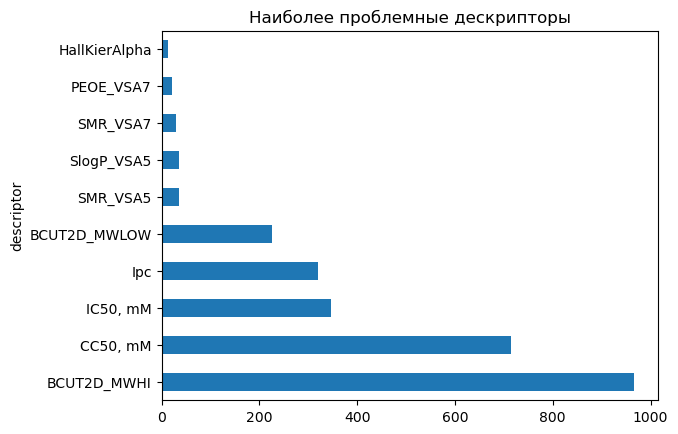

In [24]:
# Топ-10 проблемных дескрипторов
errors['descriptor'].value_counts().head(10).plot(kind='barh')
plt.title('Наиболее проблемные дескрипторы')
plt.show()


Есть подозрения на наличие ошибок в данных, однозначно ответить на этот вопрос мешает непонимание процесов проводимых исследований при создании лекарственных средств.

In [26]:
def remove_highly_correlated_features(df, target_col, threshold=0.8):
    """
    Удаляет один из признаков в высококоррелированных парах, сохраняя признак с более высокой 
    корреляцией с целевой переменной.
    
    Параметры:
    ----------
    df : DataFrame
        Входной DataFrame с данными
    target_col : str
        Название столбца с целевой переменной
    threshold : float, optional
        Порог для определения высоких корреляций между признаками (по умолчанию 0.8)
    
    Возвращает:
    -----------
    DataFrame с удаленными признаками
    """
    # Проверка наличия целевой переменной
    if target_col not in df.columns:
        raise ValueError(f"Целевая переменная '{target_col}' не найдена в DataFrame")
    
    # Вычисляем корреляции
    corr_matrix = df.corr(numeric_only=True)
    target_corrs = corr_matrix[target_col].abs().drop(target_col)
    
    # Получаем матрицу корреляций между признаками (без целевой)
    feature_corr = df.drop(columns=[target_col]).corr(numeric_only=True).abs()
    np.fill_diagonal(feature_corr.values, 0)  # Обнуляем диагональ
    
    # Находим пары с высокой корреляцией
    high_corr_pairs = (feature_corr > threshold).stack()
    high_corr_pairs = high_corr_pairs[high_corr_pairs].index
    
    # Собираем признаки для удаления
    to_drop = set()
    
    # Обрабатываем каждую пару
    for f1, f2 in high_corr_pairs:
        # Уже помечен на удаление - пропускаем
        if f1 in to_drop or f2 in to_drop:
            continue
            
        # Сравниваем корреляции с целевой переменной
        corr_f1 = target_corrs.get(f1, 0)
        corr_f2 = target_corrs.get(f2, 0)
        
        # Удаляем признак с меньшей корреляцией с целевой
        if corr_f1 > corr_f2:
            to_drop.add(f2)
        else:
            to_drop.add(f1)
    
    # Удаляем выбранные признаки
    df_reduced = df.drop(columns=to_drop)
    
    # Выводим информацию о проделанной работе
    print(f"Удалено признаков: {len(to_drop)}")
    if to_drop:
        print("Удаленные признаки:", ", ".join(sorted(to_drop)))
    
    return df_reduced

In [27]:
# Предположим, у нас есть DataFrame с целевой переменной 'IC50, mM'
df_reduced = remove_highly_correlated_features(df, target_col='IC50, mM', threshold=0.85)

# Теперь df_reduced содержит только признаки без высокой мультиколлинеарности
print(f"Исходное количество признаков: {len(df.columns)}")
print(f"Количество признаков после удаления: {len(df_reduced.columns)}")

Удалено признаков: 53
Удаленные признаки: BCUT2D_LOGPLOW, BCUT2D_MWHI, BertzCT, Chi0, Chi0n, Chi0v, Chi1, Chi1n, Chi1v, Chi2v, Chi3n, Chi3v, Chi4n, Chi4v, EState_VSA1, ExactMolWt, FpDensityMorgan2, HallKierAlpha, HeavyAtomCount, HeavyAtomMolWt, Kappa1, Kappa2, LabuteASA, MaxAbsEStateIndex, MinAbsPartialCharge, MinPartialCharge, MolWt, NOCount, NumAromaticCarbocycles, NumAromaticRings, NumHAcceptors, NumHDonors, NumSaturatedCarbocycles, NumValenceElectrons, SMR_VSA1, SMR_VSA4, SMR_VSA5, SMR_VSA7, SMR_VSA9, SlogP_VSA4, SlogP_VSA6, TPSA, VSA_EState2, VSA_EState3, VSA_EState6, fr_Al_OH_noTert, fr_Ar_NH, fr_Ar_OH, fr_COO, fr_COO2, fr_C_O_noCOO, fr_nitro_arom_nonortho, fr_phenol
Исходное количество признаков: 213
Количество признаков после удаления: 160


In [28]:
# Выделяем целевую переменную и данные для обучения
X = df.drop(['IC50, mM', 'CC50, mM', 'SI'], axis=1)  # все признаки, кроме целевых
y = df['IC50, mM']


Выбираем модель для решения задачи "Регрессия для IC50"

🔍 Обучение Linear Regression...
 Linear Regression
R²: 0.1413 | Время: 0.03s | Scaler: StandardScaler
──────────────────────────────────────────────────
🔍 Обучение Ridge (L2)...
 Ridge (L2)
R²: 0.2307 | Время: 0.01s | Scaler: StandardScaler
──────────────────────────────────────────────────
🔍 Обучение Lasso (L1)...
 Lasso (L1)
R²: 0.2206 | Время: 0.07s | Scaler: StandardScaler
──────────────────────────────────────────────────
🔍 Обучение ElasticNet...
 ElasticNet
R²: 0.3432 | Время: 0.07s | Scaler: StandardScaler
──────────────────────────────────────────────────
🔍 Обучение Random Forest...
 Random Forest
R²: 0.3862 | Время: 0.39s | Scaler: No
──────────────────────────────────────────────────
🔍 Обучение XGBoost...
 XGBoost
R²: 0.3618 | Время: 0.40s | Scaler: No
──────────────────────────────────────────────────
🔍 Обучение CatBoost...
 CatBoost
R²: 0.3961 | Время: 2.63s | Scaler: No
──────────────────────────────────────────────────


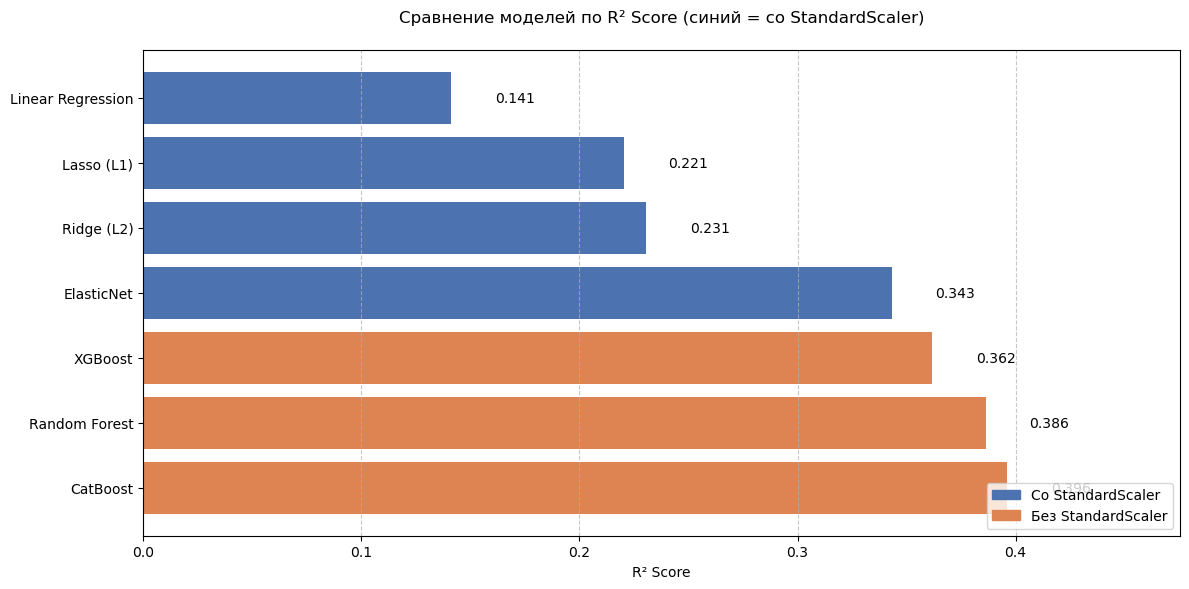

In [30]:
def test_regression_models_with_scaling(X, y, test_size=0.2, random_state=42, verbose=True):
    """
    Тестирует регрессионные модели со стандартизацией данных и возвращает результаты R².
    
    Параметры:
    ----------
    X : pd.DataFrame или np.array
        Матрица признаков
    y : pd.Series или np.array
        Целевая переменная
    test_size : float, optional
        Размер тестовой выборки (по умолчанию 0.2)
    random_state : int, optional
        Seed для воспроизводимости (по умолчанию 42)
    verbose : bool, optional
        Выводить ли прогресс (по умолчанию True)
    
    Возвращает:
    -----------
    pd.DataFrame
        Таблица с результатами R² и временем обучения для каждой модели
    """
    
    # Разделение данных
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    # Инициализация моделей с пайплайнами (StandardScaler + модель)
    models = {
        'Linear Regression': make_pipeline(StandardScaler(), LinearRegression()),
        'Ridge (L2)': make_pipeline(StandardScaler(), 
                                   Ridge(alpha=1.0, random_state=random_state)),
        'Lasso (L1)': make_pipeline(StandardScaler(), 
                                   Lasso(alpha=0.1, random_state=random_state)),
        'ElasticNet': make_pipeline(StandardScaler(), 
                                   ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=random_state)),
        'Random Forest': RandomForestRegressor(random_state=random_state, n_jobs=-1),
        'XGBoost': XGBRegressor(random_state=random_state, n_jobs=-1),
        'CatBoost': CatBoostRegressor(random_state=random_state, verbose=False)
    }
    
    # Словарь для хранения результатов
    results = {
        'Model': [],
        'R2 Score': [],
        'Train Time (s)': [],
        'Scaler Used': []
    }
    
    # Обучение и оценка моделей
    for name, model in models.items():
        if verbose:
            print(f"🔍 Обучение {name}...")
        
        try:
            start_time = time.time()
            
            # Обучение модели
            model.fit(X_train, y_train)
            train_time = time.time() - start_time
            
            # Предсказание
            y_pred = model.predict(X_test)
            
            # Расчет R²
            r2 = r2_score(y_test, y_pred)
            
            # Определение использования StandardScaler
            scaler_used = 'StandardScaler' if 'standardscaler' in str(model).lower() else 'No'
            
            # Сохранение результатов
            results['Model'].append(name)
            results['R2 Score'].append(r2)
            results['Train Time (s)'].append(train_time)
            results['Scaler Used'].append(scaler_used)
            
            if verbose:
                print(f" {name}\nR²: {r2:.4f} | Время: {train_time:.2f}s | Scaler: {scaler_used}")
                print("─" * 50)
                
        except Exception as e:
            print(f" Ошибка в {name}: {str(e)}")
            continue
    
    # Создание DataFrame с результатами
    results_df = pd.DataFrame(results).sort_values('R2 Score', ascending=False)
    
    # Визуализация результатов
    if verbose:
        plt.figure(figsize=(12, 6))
        colors = ['#4C72B0' if x == 'StandardScaler' else '#DD8452' for x in results_df['Scaler Used']]
        bars = plt.barh(results_df['Model'], results_df['R2 Score'], color=colors)
        
        # Добавление значений на график
        for bar in bars:
            width = bar.get_width()
            plt.text(width + 0.02, bar.get_y() + bar.get_height()/2,
                    f'{width:.3f}',
                    va='center', ha='left')
        
        plt.title('Сравнение моделей по R² Score (синий = со StandardScaler)', pad=20)
        plt.xlabel('R² Score')
        plt.xlim(0, min(1.1, max(results_df['R2 Score']) * 1.2))
        plt.grid(axis='x', linestyle='--', alpha=0.7)
        
        # Легенда
        import matplotlib.patches as mpatches
        blue_patch = mpatches.Patch(color='#4C72B0', label='Со StandardScaler')
        orange_patch = mpatches.Patch(color='#DD8452', label='Без StandardScaler')
        plt.legend(handles=[blue_patch, orange_patch], loc='lower right')
        
        plt.tight_layout()
        plt.show()
    
    return results_df

# Запуск расчета
results = test_regression_models_with_scaling(X, y)

Модель Catboost показала наилучшие результаты, более того низкая корреляция с целевой переменной у признаков говорит о наличиии нелинейной зависимости.

Подбираем наиболее значимые признаки для предсказания целевой переменной (на всех данных)

In [65]:
# Ищем наилучший набор признаков для повышения качества прогнозирования
def evaluate_model(X, y, model, name, test_size=0.2, random_state=42):
    """
    Оценивает производительность модели на тестовых данных.
    
    Параметры:
    ----------
    X : pandas.DataFrame или numpy.ndarray
        Матрица признаков
    y : pandas.Series или numpy.ndarray
        Целевая переменная
    model : объект модели sklearn
        Модель для оценки
    test_size : float, optional
        Доля тестовых данных (по умолчанию 0.2)
    random_state : int, optional
        Seed для воспроизводимости (по умолчанию 42)
    
    Возвращает:
    -----------
    float
        R2 score на тестовых данных
    """
    # Разделение данных на обучающую и тестовую выборки
    models = {
        'LinearRegression': LinearRegression(),
        'Ridge': Ridge(alpha=1.0),
        'Lasso': Lasso(alpha=0.1),
        'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5),
        'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
        'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
        'CatBoost': CatBoostRegressor(iterations=100, random_seed=42, verbose=False)
    }
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2,
        random_state=42
    )
    
    
    if (name == 'LinearRegression') | (name == 'Ridge') | (name == 'Lasso') | (name == 'ElasticNet'):
        model = make_pipeline(StandardScaler(), models[name])
        
    else:
        model = models[name]
    # Обучение модели и предсказание
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Возвращаем R2 score
    return r2_score(y_test, y_pred)

def find_best_feature_subset(X, y, model, name):
    """
    Находит оптимальный поднабор признаков для модели методом обратного исключения.
    
    Параметры:
    ----------
    X : pandas.DataFrame или numpy.ndarray
        Матрица признаков
    y : pandas.Series или numpy.ndarray
        Целевая переменная
    model : объект модели sklearn
        Модель для оценки
    model_name : str
        Название модели (для логов)
    
    Возвращает:
    -----------
    dict
        Словарь с результатами:
        - model: название модели
        - best_r2: лучший R2 score
        - best_features: список лучших признаков
        - num_features: количество лучших признаков
        - selector: метод отбора признаков
    """
    # Преобразование numpy array в DataFrame при необходимости
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X)
    
    # Инициализация переменных
    current_features = X.columns.tolist()  # Текущий набор признаков
    best_r2 = evaluate_model(X[current_features], y, model, name)  # Начальная оценка
    best_features = current_features.copy()  # Лучший набор признаков
    history = []  # История изменений
    
    # Запись начального состояния
    history.append({
        'features': current_features.copy(),
        'r2': best_r2,
        'action': 'initial'
    })
    
    # Вывод информации о начальной оценке
    print(f"\n=== {name} ===")
    print(f"Initial R2: {best_r2:.4f} with {len(current_features)} features")
    
    # Основной цикл исключения признаков
    improved = True
    while improved and len(current_features) > 1:
        improved = False
        worst_feature = None
        
        # Перебираем все признаки для поиска наименее значимого
        for feature in current_features:
            # Пробуем исключить текущий признак
            trial_features = [f for f in current_features if f != feature]
            current_r2 = evaluate_model(X[trial_features], y, model, name)
            
            # Запись в историю
            history.append({
                'features': trial_features.copy(),
                'r2': current_r2,
                'action': f'removed {feature}'
            })
            
            # Если качество улучшилось, обновляем лучший результат
            if current_r2 > best_r2:
                best_r2 = current_r2
                best_features = trial_features.copy()
                worst_feature = feature
                improved = True
        
        # Если улучшение было, исключаем худший признак
        if improved:
            current_features.remove(worst_feature)
    
    # Вывод результатов
    print(f"Best R2: {best_r2:.4f} with {len(best_features)} features")
    print("Optimal features:", best_features)
    
    # Возвращаем результаты в структурированном виде
    return {
        'model': name,
        'best_r2': best_r2,
        'best_features': best_features,
        'num_features': len(best_features),
        'selector': 'without selection'
    }

def test_all_models(X, y):
    """
    Тестирует все модели из предопределенного списка.
    
    Параметры:
    ----------
    X : pandas.DataFrame или numpy.ndarray
        Матрица признаков
    y : pandas.Series или numpy.ndarray
        Целевая переменная
    
    Возвращает:
    -----------
    pandas.DataFrame
        DataFrame с результатами для всех моделей
    """
    # Список тестируемых моделей с базовыми параметрами
    models = [
        ('LinearRegression', LinearRegression()),
        ('Ridge', Ridge(alpha=1.0)),
        ('Lasso', Lasso(alpha=0.1)),
        ('ElasticNet', ElasticNet(alpha=0.1, l1_ratio=0.5)),
        ('RandomForest', RandomForestRegressor(n_estimators=100, random_state=42)),
        ('XGBoost', XGBRegressor(random_state=42)),
        ('CatBoost', CatBoostRegressor(silent=True, random_state=42))
    ]
    
    results = []  # Список для хранения результатов
    
    # Тестируем каждую модель
    for name, model in models:
        try:
            # Находим лучший поднабор признаков для модели
            result = find_best_feature_subset(X, y, model, name)
            results.append(result)
        except Exception as e:
            # В случае ошибки выводим сообщение и продолжаем
            print(f"Error with {name}: {str(e)}")
            continue
    
    # Преобразуем результаты в DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df

# Запуск расчета:
results_col_combination = test_all_models(X, y)


=== LinearRegression ===
Initial R2: 0.1413 with 210 features
Best R2: 0.5529 with 134 features
Optimal features: ['MinAbsEStateIndex', 'SPS', 'MolWt', 'HeavyAtomMolWt', 'NumValenceElectrons', 'NumRadicalElectrons', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'BCUT2D_LOGPHI', 'BCUT2D_MRLOW', 'AvgIpc', 'BertzCT', 'Chi0', 'Chi0v', 'Chi1n', 'Chi1v', 'Chi3n', 'HallKierAlpha', 'Kappa2', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA11', 'SlogP_VSA3', 'SlogP_VSA4', 'SlogP_VSA5', 'SlogP_VSA6', 'SlogP_VSA9', 'EState_VSA1', 'EState_VSA10', 'EState_VSA3', 'EState_VSA6', 'EState_VSA8', 'VSA_EState1', 'VSA_EState10', 'VSA_EState2', 'VSA_EState3', 'VSA_EState4', 'VSA_EState5', 'VSA_EState6', 'VSA_EState7', 'VSA_EState8',

In [50]:
# Ищем наилучший набор признаков для повышения качества прогнозирования, через последовательное удаление признаков, упорядоченных по количеству возможных выбросов

outliers_count = pd.DataFrame({
        'feature': df.columns,
        'outliers': outliers.sum(axis=0)
    }).sort_values('outliers', ascending=False)
all_features_outliers = outliers_count['feature'][outliers_count['outliers']>0].tolist()
all_features_outliers.remove('IC50, mM')
all_features_outliers.remove('SI')
all_features_outliers.remove('CC50, mM')

def test_all_models(X, y):
    """Тестирование всех моделей по очереди"""
    # Создаем модели с дефолтными параметрами
    models = [
        ('LinearRegression', LinearRegression()),
        ('Ridge', Ridge(alpha=1.0)),
        ('Lasso', Lasso(alpha=0.1)),
        ('ElasticNet', ElasticNet(alpha=0.1, l1_ratio=0.5)),
        ('RandomForest', RandomForestRegressor(n_estimators=100, random_state=42)),
        ('XGBoost', XGBRegressor(random_state=42)),
        ('CatBoost', CatBoostRegressor(silent=True, random_state=42))
    ]
    
    results = []
    
    for name, model in models:
        try:
            result = get_features(X, y, name)
            results.append(result)
        except Exception as e:
            print(f"Error with {name}: {str(e)}")
            continue
    
    # Создаем DataFrame с результатами
    results_df = pd.DataFrame(results)
    
    
    return results_df
def get_features(X, y, name):
    """
    Отбор признаков с помощью RandomForest с оптимизацией по R2
    
    Возвращает:
    - best_features: список лучших признаков
    - best_r2: лучшее значение R2
    - all_features: все признаки отсортированные по важности
    """
    
    
    # Находим оптимальное количество признаков
    best_r2 = -np.inf
    best_features = []
    
    for n in range(1, len(all_features_outliers)+1):
        
        current_features = X.drop(columns = all_features_outliers[:n]).columns.tolist()
        
        current_r2 = evaluate_r2(X[current_features], y, name)
        if current_r2 > best_r2:
            best_r2 = current_r2
            best_features = current_features.copy()
    
    print(f"\n=== {name} ===\n")
    print(f"Best R2: {best_r2:.4f} with {len(best_features)} features")
    print("Optimal features:", best_features)
    return {
        'model': name,
        'best_r2': best_r2,
        'best_features': best_features,
        'num_features': len(best_features),
        'selector': 'outliers'
    }
def evaluate_r2(X, y, name):
    """
    Вспомогательная функция для оценки R2
    """
    models = {
        'LinearRegression': LinearRegression(),
        'Ridge': Ridge(alpha=1.0),
        'Lasso': Lasso(alpha=0.1),
        'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5),
        'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
        'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
        'CatBoost': CatBoostRegressor(iterations=100, random_seed=42, verbose=False)
    }
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2,
        random_state=42
    )
    
    
    if (name == 'LinearRegression') | (name == 'Ridge') | (name == 'Lasso') | (name == 'ElasticNet'):
        model = make_pipeline(StandardScaler(), models[name])
        
    else:
        model = models[name]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    return r2_score(y_test, y_pred)
    
# Запуск расчета
results_col_combination_2 = test_all_models(X, y)


=== LinearRegression ===

Best R2: 0.3395 with 103 features
Optimal features: ['MinAbsEStateIndex', 'qed', 'SPS', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'AvgIpc', 'Chi2v', 'HallKierAlpha', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA6', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA7', 'SMR_VSA8', 'SlogP_VSA1', 'SlogP_VSA12', 'SlogP_VSA2', 'SlogP_VSA4', 'SlogP_VSA6', 'SlogP_VSA9', 'TPSA', 'EState_VSA11', 'EState_VSA4', 'EState_VSA6', 'EState_VSA8', 'VSA_EState2', 'VSA_EState4', 'VSA_EState6', 'VSA_EState7', 'FractionCSP3', 'NHOHCount', 'NOCount', 'NumAliphaticCarbocycles', 'NumAliphaticHeterocycles', 'NumAliphaticRings', 'NumAromaticCarbocycles', 'NumAromaticHeterocycles', 'NumAromaticRings', 'NumHDonors', 'NumHeteroatoms', 'NumSaturatedCarbocycles', 'NumSaturatedHeterocycles', 'N

In [51]:
# Ищем наилучший набор признаков с учетом значимости признаков определенных с помощью SHAP

def test_tree_models_sh(X, y):
    """Тестирование всех моделей по очереди"""
    # Создаем модели с дефолтными параметрами
    models = {
        "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
        "XGBoost": XGBRegressor(random_state=42),
        "CatBoost": CatBoostRegressor(silent=True, random_state=42),
    }
    
    results = []
    
    for name, model in models.items():
        try:
            result = get_shap_selection(X, y, name)
            results.append(result)
        except Exception as e:
            print(f"Error with {name}: {str(e)}")
            continue
    
    # Создаем DataFrame с результатами
    results_df = pd.DataFrame(results)
    
    
    return results_df
def get_shap_selection(X, y, name):
    """
    Отбор признаков с помощью RandomForest с оптимизацией по R2
    
    Возвращает:
    - best_features: список лучших признаков
    - best_r2: лучшее значение R2
    - all_features: все признаки отсортированные по важности
    """
    feature_names = X.columns.tolist()
    if name == 'RandomForest':
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X, y)
        explainer = shap.Explainer(model)
        shap_values = explainer(X)
        importance = get_significant_shap_features(shap_values, feature_names)
    elif name == 'XGBoost':
        model = XGBRegressor(n_estimators=100, random_state=42)
        model.fit(X, y)
        explainer = shap.Explainer(model)
        shap_values = explainer(X)
        importance = get_significant_shap_features(shap_values, feature_names)
    elif name == 'CatBoost':
        model = CatBoostRegressor(
        iterations=100,
        random_seed=42,
        verbose=False
        )
        model.fit(X, y)
        explainer = shap.Explainer(model)
        shap_values = explainer(X)
        importance = get_significant_shap_features(shap_values, feature_names)
   
    feat_importance = pd.DataFrame({
        'feature': importance['feature'],
        'importance': importance['mean_abs_shap']
    }).sort_values('importance', ascending=False)
    
    all_features = feat_importance['feature'][feat_importance['importance']>0].tolist()
    # Находим оптимальное количество признаков
    best_r2 = -np.inf
    best_features = []
    
    for n in range(1, len(all_features)+1):
        
        current_features = all_features[:n]
        current_r2 = evaluate_r2_feature_selection(X[current_features], y, name)
        if current_r2 > best_r2:
            best_r2 = current_r2
            best_features = current_features.copy()
    print(f"\n=== {name} ===\n")
    print(f"Best R2: {best_r2:.4f} with {len(best_features)} features")
    print("Optimal features:", best_features)
    return {
        'model': name,
        'best_r2': best_r2,
        'best_features': best_features,
        'num_features': len(best_features),
        'selector': 'shap_selection'
    }

def evaluate_r2_feature_selection(X, y, model, test_size=0.2, random_state=42):
    """
    Вспомогательная функция для оценки R2
    """
    models = {
        "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
        "XGBoost": XGBRegressor(random_state=42),
        "CatBoost": CatBoostRegressor(silent=True, random_state=42),
    }
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=test_size, 
        random_state=random_state
    )
    
    model = models[model]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    return r2_score(y_test, y_pred)
def get_significant_shap_features(shap_values, feature_names, threshold=0):
    """
    Возвращает отсортированный по убыванию список признаков с SHAP-значимостью выше threshold
    
    Параметры:
    ----------
    shap_values : shap.Explanation или np.ndarray
        SHAP значения для всех наблюдений
    feature_names : list или pd.Index
        Список названий признаков
    threshold : float, optional
        Порог значимости (по умолчанию 0)
    
    Возвращает:
    -----------
    pd.DataFrame: DataFrame с колонками 'feature' и 'mean_abs_shap',
                  отсортированный по убыванию важности
    """
    # Если передан объект Explanation
    if isinstance(shap_values, shap.Explanation):
        shap_array = shap_values.values
    else:
        shap_array = shap_values
    
    # Рассчитываем среднюю абсолютную важность по всем наблюдениям
    mean_abs_shap = np.abs(shap_array).mean(axis=0)
    
    # Создаем DataFrame
    shap_importance = pd.DataFrame({
        'feature': feature_names,
        'mean_abs_shap': mean_abs_shap
    })
    
    # Фильтруем по порогу и сортируем
    significant_features = shap_importance[shap_importance['mean_abs_shap'] > threshold] \
        .sort_values('mean_abs_shap', ascending=False)
    
    return significant_features.reset_index(drop=True)

# Запуск расчета
results_col_combination_3 = test_tree_models_sh(X, y)


=== RandomForest ===

Best R2: 0.4379 with 15 features
Optimal features: ['VSA_EState4', 'FpDensityMorgan3', 'EState_VSA5', 'BCUT2D_MRLOW', 'Chi1n', 'BCUT2D_MWLOW', 'Chi2v', 'VSA_EState8', 'NHOHCount', 'EState_VSA8', 'NumSaturatedHeterocycles', 'SlogP_VSA5', 'qed', 'VSA_EState1', 'EState_VSA7']

=== XGBoost ===

Best R2: 0.5320 with 18 features
Optimal features: ['Chi2v', 'VSA_EState4', 'FpDensityMorgan3', 'BCUT2D_MRLOW', 'BCUT2D_MWLOW', 'EState_VSA5', 'EState_VSA3', 'Chi1v', 'VSA_EState8', 'qed', 'VSA_EState2', 'NumSaturatedHeterocycles', 'PEOE_VSA6', 'Chi4n', 'BCUT2D_MWHI', 'EState_VSA2', 'NHOHCount', 'MinAbsEStateIndex']

=== CatBoost ===

Best R2: 0.4299 with 81 features
Optimal features: ['VSA_EState4', 'EState_VSA5', 'Chi2n', 'FpDensityMorgan3', 'BCUT2D_MRLOW', 'MolLogP', 'HeavyAtomMolWt', 'FpDensityMorgan1', 'VSA_EState1', 'EState_VSA7', 'PEOE_VSA9', 'BCUT2D_MWHI', 'Chi1n', 'VSA_EState7', 'VSA_EState5', 'qed', 'Chi3v', 'PEOE_VSA6', 'BalabanJ', 'EState_VSA8', 'Chi4v', 'EState_VS

In [52]:
# Ищем наилучший набор признаков с учетом значимости признаков определенных с помощью features importance

def test_tree_models_fs(X, y):
    """Тестирование всех моделей по очереди"""
    # Создаем модели с дефолтными параметрами
    models = {
        "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
        "XGBoost": XGBRegressor(random_state=42),
        "CatBoost": CatBoostRegressor(silent=True, random_state=42),
    }
    
    results = []
    
    for name, model in models.items():
        try:
            result = get_feature_selection(X, y, name)
            results.append(result)
        except Exception as e:
            print(f"Error with {name}: {str(e)}")
            continue
    
    # Создаем DataFrame с результатами
    results_df = pd.DataFrame(results)
    
    
    return results_df
def get_feature_selection(X, y, name):
    """
    Отбор признаков с помощью RandomForest с оптимизацией по R2
    
    Возвращает:
    - best_features: список лучших признаков
    - best_r2: лучшее значение R2
    - all_features: все признаки отсортированные по важности
    """
    feature_names = X.columns.tolist()
    if name == 'RandomForest':
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X, y)
        
    elif name == 'XGBoost':
        model = XGBRegressor(n_estimators=100, random_state=42)
        model.fit(X, y)
        
    elif name == 'CatBoost':
        model = CatBoostRegressor(
        iterations=100,
        random_seed=42,
        verbose=False
        )
        model.fit(X, y)
        
    importance = model.feature_importances_
    
    # Сортируем признаки по важности
    feat_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': importance
    }).sort_values('importance', ascending=False)
    
    all_features = feat_importance['feature'][feat_importance['importance']>0].tolist()
    # Находим оптимальное количество признаков
    best_r2 = -np.inf
    best_features = []
    
    for n in range(1, len(all_features)+1):
        
        current_features = all_features[:n]
        current_r2 = evaluate_r2_feature_selection(X[current_features], y, name)
        if current_r2 > best_r2:
            best_r2 = current_r2
            best_features = current_features.copy()
    print(f"\n=== {name} ===\n")
    print(f"Best R2: {best_r2:.4f} with {len(best_features)} features")
    print("Optimal features:", best_features)
    return {
        'model': name,
        'best_r2': best_r2,
        'best_features': best_features,
        'num_features': len(best_features),
        'selector': 'feature_selection'
    }

def evaluate_r2_feature_selection(X, y, model, test_size=0.2, random_state=42):
    """
    Вспомогательная функция для оценки R2
    """
    models = {
        "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
        "XGBoost": XGBRegressor(random_state=42),
        "CatBoost": CatBoostRegressor(silent=True, random_state=42),
    }
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=test_size, 
        random_state=random_state
    )
    
    model = models[model]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    return r2_score(y_test, y_pred)

# Запуск расчета
results_col_combination_4 = test_tree_models_fs(X, y)


=== RandomForest ===

Best R2: 0.4671 with 2 features
Optimal features: ['BCUT2D_MWLOW', 'VSA_EState4']

=== XGBoost ===

Best R2: 0.5198 with 10 features
Optimal features: ['BCUT2D_MWLOW', 'Chi1v', 'fr_sulfonamd', 'fr_Al_OH', 'NumSaturatedHeterocycles', 'NHOHCount', 'SMR_VSA1', 'Chi2v', 'VSA_EState4', 'BCUT2D_MRLOW']

=== CatBoost ===

Best R2: 0.4746 with 2 features
Optimal features: ['VSA_EState4', 'BCUT2D_MWLOW']


In [67]:
# Объединяем все лучшие результаты
results_df = pd.concat([results_col_combination,results_col_combination_2, results_col_combination_3, results_col_combination_4], ignore_index = True)

In [71]:
results_df

,model,best_r2,best_features,num_features,selector
0,LinearRegression,0.552945,"[MinAbsEStateIndex, SPS, MolWt, HeavyAtomMolWt...",134,without selection
1,Ridge,0.612209,"[MaxAbsEStateIndex, MaxEStateIndex, MinAbsESta...",114,without selection
2,Lasso,0.614452,"[MaxEStateIndex, MinAbsEStateIndex, SPS, Exact...",104,without selection
3,ElasticNet,0.517275,"[MinAbsEStateIndex, MolWt, HeavyAtomMolWt, Exa...",116,without selection
4,RandomForest,0.449282,"[MaxAbsEStateIndex, MaxEStateIndex, MinAbsESta...",206,without selection
5,XGBoost,0.504857,"[MaxAbsEStateIndex, MaxEStateIndex, MinAbsESta...",198,without selection
6,CatBoost,0.474744,"[MaxAbsEStateIndex, MaxEStateIndex, MinAbsESta...",209,without selection
7,LinearRegression,0.339510,"[MinAbsEStateIndex, qed, SPS, NumRadicalElectr...",103,outliers
8,Ridge,0.347824,"[MinAbsEStateIndex, qed, SPS, NumRadicalElectr...",103,outliers
9,Lasso,0.344370,"[MinAbsEStateIndex, qed, SPS, NumRadicalElectr...",103,outliers


In [73]:
# Определяем налучший результат работы моделей
def test_all_models(X, y):
    """Тестирование всех моделей по очереди"""
    # Создаем модели с дефолтными параметрами
    models = [
        ('LinearRegression', LinearRegression()),
        ('Ridge', Ridge(alpha=1.0)),
        ('Lasso', Lasso(alpha=0.1)),
        ('ElasticNet', ElasticNet(alpha=0.1, l1_ratio=0.5)),
        ('RandomForest', RandomForestRegressor(n_estimators=100, random_state=42)),
        ('XGBoost', XGBRegressor(random_state=42)),
        ('CatBoost', CatBoostRegressor(silent=True, random_state=42))
    ]
    
    results = []
    
    for name, model in models:
        try:
            result = get_res_features(X, y, name)
            results.append(result)
        except Exception as e:
            print(f"Error with {name}: {str(e)}")
            continue
    
    # Создаем DataFrame с результатами
    results_df = pd.DataFrame(results)
    
    
    return results_df
def get_res_features(X, y, name):
    """
    Отбор признаков с помощью RandomForest с оптимизацией по R2
    
    Возвращает:
    - best_features: список лучших признаков
    - best_r2: лучшее значение R2
    - all_features: все признаки отсортированные по важности
    """
    
    
    # Находим оптимальное количество признаков
    best_r2 = -np.inf
    best_features = []
    res_features = results_df['best_features'].tolist()
    for current_features in res_features:
        
        current_r2 = evaluate_r2(X[current_features], y, name)
        if current_r2 > best_r2:
            best_r2 = current_r2
            best_features = current_features.copy()
    
    print(f"\n=== {name} ===\n")
    print(f"Best R2: {best_r2:.4f} with {len(best_features)} features")
    print("Optimal features:", best_features)
    return {
        'model': name,
        'best_r2': best_r2,
        'best_features': best_features,
        'num_features': len(best_features),
        
    }
def evaluate_r2(X, y, name):
    """
    Вспомогательная функция для оценки R2
    """
    models = {
        'LinearRegression': LinearRegression(),
        'Ridge': Ridge(alpha=1.0),
        'Lasso': Lasso(alpha=0.1),
        'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5),
        'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
        'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
        'CatBoost': CatBoostRegressor(iterations=100, random_seed=42, verbose=False)
    }
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2,
        random_state=42
    )
    if (name == 'LinearRegression') | (name == 'Ridge') | (name == 'Lasso') | (name == 'ElasticNet'):
        model = make_pipeline(StandardScaler(), models[name])
        
    else:
        model = models[name]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    return r2_score(y_test, y_pred)

# Запуск расчета
results_features_selection = test_all_models(X, y)


=== LinearRegression ===

Best R2: 0.6242 with 114 features
Optimal features: ['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex', 'SPS', 'MolWt', 'HeavyAtomMolWt', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRLOW', 'AvgIpc', 'Chi0', 'Chi2n', 'Chi3n', 'Chi3v', 'Chi4n', 'HallKierAlpha', 'Kappa1', 'Kappa3', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA5', 'SMR_VSA7', 'SMR_VSA8', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11', 'SlogP_VSA12', 'SlogP_VSA5', 'SlogP_VSA6', 'SlogP_VSA9', 'EState_VSA1', 'EState_VSA10', 'EState_VSA11', 'EState_VSA3', 'EState_VSA9', 'VSA_EState2', 'VSA_EState5', 'VSA_EState8', 'FractionCSP3', 'NHOHCount', 'NumAliphaticHeterocycles', 'NumSaturatedRing

In [77]:
# Определяем лучшую комбинацию строк, учитывая строки с подозрением на выбросы, для повышения качества работы моделей

def test_outlier_strings(X, y,outliers):
    """Тестирование всех моделей по очереди"""
    # Создаем модели с дефолтными параметрами
    models = [
        ('LinearRegression', LinearRegression()),
        ('Ridge', Ridge(alpha=1.0)),
        ('Lasso', Lasso(alpha=0.1)),
        ('ElasticNet', ElasticNet(alpha=0.1, l1_ratio=0.5)),
        ('RandomForest', RandomForestRegressor(n_estimators=100, random_state=42)),
        ('XGBoost', XGBRegressor(random_state=42)),
        ('CatBoost', CatBoostRegressor(silent=True, random_state=42))
    ]
    
    results = []
    
    for name, model in models:
        try:
            result = optimize_outlier_removal(X, y, outliers,name, model)
            results.append(result)
        except Exception as e:
            print(f"Error with {name}: {str(e)}")
            continue
    
    # Создаем DataFrame с результатами
    results_df = pd.DataFrame(results)
    
    
    return results_df
def optimize_outlier_removal(X, y, outliers,name, model=None):
    """
    Последовательно удаляет строки с выбросами и проверяет влияние на R²
    
    Параметры:
    ----------
    df : pd.DataFrame
        Исходный DataFrame с признаками
    y : pd.Series
        Целевая переменная
    outliers_df : pd.DataFrame
        DataFrame с флагами выбросов (True - выброс)
    model : sklearn модель, optional
        Модель для оценки (по умолчанию RandomForestRegressor)
    test_size : float, optional
        Размер тестовой выборки
    random_state : int, optional
        Seed для воспроизводимости
        
    Возвращает:
    -----------
    pd.DataFrame: Оптимизированный DataFrame без ухудшающих качество выбросов
    float: Лучшее значение R²
    """
    models = {
        'LinearRegression': LinearRegression(),
        'Ridge': Ridge(alpha=1.0),
        'Lasso': Lasso(alpha=0.1),
        'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5),
        'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
        'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
        'CatBoost': CatBoostRegressor(iterations=100, random_seed=42, verbose=False)
    }
    
    if name == 'LinearRegression':
        X = X[results_features_selection[results_features_selection['model'] == name]['best_features'][0]]
        
    elif name == 'Ridge':
        X = X[results_features_selection[results_features_selection['model'] == name]['best_features'][1]]
        
    elif name == 'Lasso':
        X = X[results_features_selection[results_features_selection['model'] == name]['best_features'][2]]
    elif name == 'ElasticNet':
        X = X[results_features_selection[results_features_selection['model'] == name]['best_features'][3]]
    elif name == 'RandomForest':
        X = X[results_features_selection[results_features_selection['model'] == name]['best_features'][4]]
    elif name == 'XGBoost':
        X = X[results_features_selection[results_features_selection['model'] == name]['best_features'][5]]
    elif name == 'CatBoost':
        X = X[results_features_selection[results_features_selection['model'] == name]['best_features'][6]]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=42
    )
    
    # Инициализация
    X_opt = X_train.copy()
    y_opt = y_train.copy()
    best_r2 = -np.inf
    removed_indices = []
    # Получаем все выбросы
    
    train_outliers = outliers.loc[X_train.index]
    mask_outliers = ((outliers['SI']) | (outliers['IC50, mM'])| (outliers['CC50, mM']))
    clean_df = train_outliers[mask_outliers]

    for idx in clean_df.index.tolist():
        # Временно удаляем строку
        X_temp = X_opt.drop(index=idx)
        y_temp = y_opt.drop(index=idx)
        
        # Обучаем и оцениваем
        if (name == 'LinearRegression') | (name == 'Ridge') | (name == 'Lasso') | (name == 'ElasticNet'):
            model = make_pipeline(StandardScaler(), models[name])
        
        else:
            model = models[name]
        model.fit(X_temp, y_temp)
        y_pred = model.predict(X_test)
        current_r2 = r2_score(y_test, y_pred)
        
        # Решение о сохранении/удалении строки
        if current_r2 > best_r2:
            best_r2 = current_r2
            X_opt = X_temp
            y_opt = y_temp
            removed_indices.append(idx)
    
    print(f"\n=== {name} ===")
    print(f"\nИтоговый R²: {best_r2:.4f}")
    print(f"Удалено строк: {len(removed_indices)} из {len(X_train)}")
    return {
        'model': name,
        'best_r2': best_r2,
        'removed_indices': removed_indices,
        'num_removed': len(removed_indices),
        'indices': X_opt.index,
        'selector': 'outlier_selection'
    }

# Запуск расчета
results_ind_outliers = test_outlier_strings(X, y,outliers)   


=== LinearRegression ===

Итоговый R²: 0.6756
Удалено строк: 102 из 772

=== Ridge ===

Итоговый R²: 0.6680
Удалено строк: 90 из 772

=== Lasso ===

Итоговый R²: 0.6739
Удалено строк: 105 из 772

=== ElasticNet ===

Итоговый R²: 0.5880
Удалено строк: 102 из 772

=== RandomForest ===

Итоговый R²: 0.5949
Удалено строк: 7 из 772

=== XGBoost ===

Итоговый R²: 0.5849
Удалено строк: 10 из 772

=== CatBoost ===

Итоговый R²: 0.5958
Удалено строк: 8 из 772


In [89]:
# Определяем лучшую комбинацию строк для повышения качества работы моделей на всех данных
def test_all_models_strings(X, y):
    """Тестирование всех моделей по очереди"""
    # Создаем модели с дефолтными параметрами
    models = [
        ('LinearRegression', LinearRegression()),
        ('Ridge', Ridge(alpha=1.0)),
        ('Lasso', Lasso(alpha=0.1)),
        ('ElasticNet', ElasticNet(alpha=0.1, l1_ratio=0.5)),
        ('RandomForest', RandomForestRegressor(n_estimators=100, random_state=42)),
        ('XGBoost', XGBRegressor(random_state=42)),
        ('CatBoost', CatBoostRegressor(silent=True, random_state=42))
    ]
    
    results = []
    
    for name, model in models:
        try:
            result = optimize_training_set(X, y, name, model)
            results.append(result)
        except Exception as e:
            print(f"Error with {name}: {str(e)}")
            continue
    
    # Создаем DataFrame с результатами
    results_df = pd.DataFrame(results)
    
    
    return results_df
def optimize_training_set(X, y, name, model, verbose=True):
    """
    Оптимизирует состав тренировочных данных путем последовательного удаления строк.
    
    Параметры:
    ----------
    X_train, y_train: pd.DataFrame/pd.Series
        Обучающие данные
    X_test, y_test: pd.DataFrame/pd.Series
        Тестовые данные для валидации
    model_params: dict
        Параметры XGBoost (по умолчанию: {'n_estimators': 100, 'random_state': 42})
    verbose: bool
        Выводить ли прогресс
    
    Возвращает:
    -----------
    pd.Index: Индексы оптимального подмножества обучающих данных
    """
    models = {
        'LinearRegression': LinearRegression(),
        'Ridge': Ridge(alpha=1.0),
        'Lasso': Lasso(alpha=0.1),
        'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5),
        'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
        'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
        'CatBoost': CatBoostRegressor(iterations=100, random_seed=42, verbose=False)
    }
    if name == 'LinearRegression':
        X = X[results_features_selection[results_features_selection['model'] == name]['best_features'][0]]
        
    elif name == 'Ridge':
        X = X[results_features_selection[results_features_selection['model'] == name]['best_features'][1]]
        
    elif name == 'Lasso':
        X = X[results_features_selection[results_features_selection['model'] == name]['best_features'][2]]
    elif name == 'ElasticNet':
        X = X[results_features_selection[results_features_selection['model'] == name]['best_features'][3]]
    elif name == 'RandomForest':
        X = X[results_features_selection[results_features_selection['model'] == name]['best_features'][4]]
    elif name == 'XGBoost':
        X = X[results_features_selection[results_features_selection['model'] == name]['best_features'][5]]
    elif name == 'CatBoost':
        X = X[results_features_selection[results_features_selection['model'] == name]['best_features'][6]]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=42
    )
    
    # Создаем копии для безопасного удаления строк
    X_opt = X_train.copy()
    y_opt = y_train.copy()
    best_r2 = -np.inf
    removed_indices = []
    
    for idx in X_train.index:
        # Временно удаляем строку
        X_temp = X_opt.drop(index=idx)
        y_temp = y_opt.drop(index=idx)
        
        # Обучаем и оцениваем
        if (name == 'LinearRegression') | (name == 'Ridge') | (name == 'Lasso') | (name == 'ElasticNet'):
            model = make_pipeline(StandardScaler(), models[name])
        
        else:
            model = models[name]
        model.fit(X_temp, y_temp)
        y_pred = model.predict(X_test)
        current_r2 = r2_score(y_test, y_pred)
        
        # Решение о сохранении/удалении строки
        if current_r2 > best_r2:
            best_r2 = current_r2
            X_opt = X_temp
            y_opt = y_temp
            removed_indices.append(idx)
            
    print(f"\n=== {name} ===")
    print(f"\nИтоговый R²: {best_r2:.4f}")
    print(f"Удалено строк: {len(removed_indices)} из {len(X_train)}")
    return {
        'model': name,
        'best_r2': best_r2,
        'removed_indices': removed_indices,
        'num_removed': len(removed_indices),
        'indices': X_opt.index,
        'selector': 'without selection'
    }

# Запуск расчета
results_ind_combination = test_all_models_strings(X, y)   


=== LinearRegression ===

Итоговый R²: 0.7173
Удалено строк: 281 из 772

=== Ridge ===

Итоговый R²: 0.7069
Удалено строк: 294 из 772

=== Lasso ===

Итоговый R²: 0.7147
Удалено строк: 311 из 772

=== ElasticNet ===

Итоговый R²: 0.6469
Удалено строк: 399 из 772

=== RandomForest ===

Итоговый R²: 0.5570
Удалено строк: 11 из 772

=== XGBoost ===

Итоговый R²: 0.5588
Удалено строк: 7 из 772

=== CatBoost ===

Итоговый R²: 0.6029
Удалено строк: 15 из 772


In [90]:
# Объединяем полученные результаты
results_indices_df = pd.concat([results_ind_outliers, results_ind_combination], ignore_index = True)

In [185]:
# Определяем налучшую комбинацию строк для повышения качества работы моделей

def test_all_models_strings(X, y):
    """Тестирование всех моделей по очереди"""
    # Создаем модели с дефолтными параметрами
    models = [
        ('LinearRegression', LinearRegression()),
        ('Ridge', Ridge(alpha=1.0)),
        ('Lasso', Lasso(alpha=0.1)),
        ('ElasticNet', ElasticNet(alpha=0.1, l1_ratio=0.5)),
        ('RandomForest', RandomForestRegressor(n_estimators=100, random_state=42)),
        ('XGBoost', XGBRegressor(random_state=42)),
        ('CatBoost', CatBoostRegressor(silent=True, random_state=42))
    ]
    
    results = []
    
    for name, model in models:
        try:
            result = optimize_training_set(X, y, name, model)
            results.append(result)
        except Exception as e:
            print(f"Error with {name}: {str(e)}")
            continue
    
    # Создаем DataFrame с результатами
    results_df = pd.DataFrame(results)
    
    
    return results_df
def optimize_training_set(X, y, name, model, verbose=True):
    """
    Оптимизирует состав тренировочных данных путем последовательного удаления строк.
    
    Параметры:
    ----------
    X_train, y_train: pd.DataFrame/pd.Series
        Обучающие данные
    X_test, y_test: pd.DataFrame/pd.Series
        Тестовые данные для валидации
    model_params: dict
        Параметры XGBoost (по умолчанию: {'n_estimators': 100, 'random_state': 42})
    verbose: bool
        Выводить ли прогресс
    
    Возвращает:
    -----------
    pd.Index: Индексы оптимального подмножества обучающих данных
    """
    models = {
        'LinearRegression': LinearRegression(),
        'Ridge': Ridge(alpha=1.0),
        'Lasso': Lasso(alpha=0.1),
        'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5),
        'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
        'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
        'CatBoost': CatBoostRegressor(iterations=100, random_seed=42, verbose=False)
    }
    if name == 'LinearRegression':
        X = X[results_features_selection[results_features_selection['model'] == name]['best_features'][0]]
        
    elif name == 'Ridge':
        X = X[results_features_selection[results_features_selection['model'] == name]['best_features'][1]]
        
    elif name == 'Lasso':
        X = X[results_features_selection[results_features_selection['model'] == name]['best_features'][2]]
    elif name == 'ElasticNet':
        X = X[results_features_selection[results_features_selection['model'] == name]['best_features'][3]]
    elif name == 'RandomForest':
        X = X[results_features_selection[results_features_selection['model'] == name]['best_features'][4]]
    elif name == 'XGBoost':
        X = X[results_features_selection[results_features_selection['model'] == name]['best_features'][5]]
    elif name == 'CatBoost':
        X = X[results_features_selection[results_features_selection['model'] == name]['best_features'][6]]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=42
    )
    
    # Создаем копии для безопасного удаления строк
    X_opt = X_train.copy()
    y_opt = y_train.copy()
    best_r2 = -np.inf
    
    removed_indices = results_indices_df['removed_indices'].tolist()
    
    for idx in removed_indices:
        
        # Временно удаляем строку
        X_temp = X_train.drop(idx)
        y_temp = y_train.drop(idx)
        if (name == 'LinearRegression') | (name == 'Ridge') | (name == 'Lasso') | (name == 'ElasticNet'):
            model = make_pipeline(StandardScaler(), models[name])
        
        else:
            model = models[name]
        model.fit(X_temp, y_temp)
        y_pred = model.predict(X_test)
        current_r2 = r2_score(y_test, y_pred)
        # Решение о сохранении/удалении строки
        if current_r2 > best_r2:
            best_r2 = current_r2
            X_opt = X_temp
            y_opt = y_temp
            ind = idx
    
    print(f"\n=== {name} ===")
    print(f"\nИтоговый R²: {best_r2:.4f}")
    print(f"Удалено строк: {len(ind)} из {len(X_train)}")
    return {
        'model': name,
        'best_r2': best_r2,
        'removed_indices': ind,
        'num_removed': len(ind),
        'indices': X_opt.index.tolist(),
        'selector': 'without selection'
    }
    
# Запуск расчета
results_indices_selection = test_all_models_strings(X, y)   


=== LinearRegression ===

Итоговый R²: 0.7173
Удалено строк: 281 из 772

=== Ridge ===

Итоговый R²: 0.7069
Удалено строк: 294 из 772

=== Lasso ===

Итоговый R²: 0.7147
Удалено строк: 311 из 772

=== ElasticNet ===

Итоговый R²: 0.6469
Удалено строк: 399 из 772

=== RandomForest ===

Итоговый R²: 0.6107
Удалено строк: 90 из 772

=== XGBoost ===

Итоговый R²: 0.5849
Удалено строк: 10 из 772

=== CatBoost ===

Итоговый R²: 0.6029
Удалено строк: 15 из 772


In [92]:
results_indices_selection

,model,best_r2,removed_indices,num_removed,indices,selector
0,LinearRegression,0.717347,"[740, 317, 309, 457, 77, 245, 390, 228, 329, 3...",281,"[202, 957, 821, 117, 999, 86, 344, 540, 976, 2...",without selection
1,Ridge,0.706903,"[740, 317, 309, 457, 77, 245, 390, 86, 228, 32...",294,"[202, 957, 821, 117, 999, 344, 540, 2, 367, 64...",without selection
2,Lasso,0.714723,"[740, 317, 309, 457, 77, 245, 390, 86, 228, 97...",311,"[202, 957, 821, 117, 999, 329, 344, 540, 2, 36...",without selection
3,ElasticNet,0.646920,"[740, 202, 317, 957, 309, 821, 457, 999, 77, 2...",399,"[117, 390, 344, 976, 367, 264, 218, 308, 866, ...",without selection
4,RandomForest,0.610674,"[202, 77, 245, 86, 109, 519, 526, 25, 950, 302...",90,"[740, 317, 957, 309, 821, 457, 117, 999, 390, ...",without selection
5,XGBoost,0.584862,"[202, 821, 77, 245, 344, 734, 512, 475, 774, 724]",10,"[740, 317, 957, 309, 457, 117, 999, 390, 86, 2...",without selection
6,CatBoost,0.602851,"[740, 202, 317, 645, 866, 343, 28, 179, 183, 6...",15,"[957, 309, 821, 457, 117, 999, 77, 245, 390, 8...",without selection


In [163]:
# Подбор гиперпараметров для линейных моделей

def optimize_linear_model(X_train, X_test, y_train, y_test, model_type='ridge', n_trials=100, random_state=42, initial_params=None):
    """
    Оптимизирует гиперпараметры для Ridge, Lasso или ElasticNet с исправлениями.
    """
    
    def objective(trial):
        try:
            alpha = trial.suggest_float('alpha', 1e-6, 100, log=True)
            
            if model_type == 'elasticnet':
                l1_ratio = trial.suggest_float('l1_ratio', 0.01, 0.99)
                model = make_pipeline(StandardScaler(),ElasticNet(alpha=alpha, l1_ratio=l1_ratio))
            elif model_type == 'lasso':
                model = make_pipeline(StandardScaler(),Lasso(alpha=alpha))
            else:  # ridge
                model = make_pipeline(StandardScaler(),Ridge(alpha=alpha))
            
            model.fit( X_train, y_train)
    
            # Предсказание на тестовых данных
            y_pred = model.predict(X_test)
            
            # Расчет метрик
            #rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            r2 = r2_score(y_test, y_pred)
            
            # Сохраняем R² как дополнительный атрибут
            #trial.set_user_attr("r2", r2)
            
            return r2
            
        except Exception as e:
            print(f"Ошибка в trial: {e}")
            return -np.inf  # Возвращаем -inf при ошибке
    
    # Настройка Optuna
    study = optuna.create_study(
        direction='maximize',
        sampler=optuna.samplers.TPESampler(seed=random_state),
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=10)
    )
    if initial_params is not None:
        study.enqueue_trial(initial_params)
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
    
    return {
        'best_params': study.best_params,
        'best_score': study.best_value,
        'study': study
    }
    

In [165]:

# Запуск подбора гиперпараметров

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_ridge = X_train[results_features_selection[results_features_selection['model'] == 'Ridge']['best_features'][1]].drop(results_indices_selection[results_indices_selection['model'] == 'Ridge']['removed_indices'][1])
y_train_ridge = y_train.drop(results_indices_selection[results_indices_selection['model'] == 'Ridge']['removed_indices'][1])
X_test_ridge = X_test[results_features_selection[results_features_selection['model'] == 'Ridge']['best_features'][1]]
ridge_results = optimize_linear_model(X_train_ridge, X_test_ridge, y_train_ridge, y_test, 'ridge', n_trials=500, initial_params = {'alpha': 1.0})

X_train_lasso = X_train[results_features_selection[results_features_selection['model'] == 'Lasso']['best_features'][2]].drop(results_indices_selection[results_indices_selection['model'] == 'Lasso']['removed_indices'][2])
y_train_lasso = y_train.drop(results_indices_selection[results_indices_selection['model'] == 'Lasso']['removed_indices'][2])
X_test_lasso = X_test[results_features_selection[results_features_selection['model'] == 'Lasso']['best_features'][2]]
lasso_results = optimize_linear_model(X_train_lasso, X_test_lasso, y_train_lasso, y_test, 'lasso', n_trials=500, initial_params = {'alpha': 0.1})
X_train_elastic = X_train[results_features_selection[results_features_selection['model'] == 'ElasticNet']['best_features'][3]].drop(results_indices_selection[results_indices_selection['model'] == 'ElasticNet']['removed_indices'][3])
y_train_elastic = y_train.drop(results_indices_selection[results_indices_selection['model'] == 'ElasticNet']['removed_indices'][3])
X_test_elastic = X_test[results_features_selection[results_features_selection['model'] == 'ElasticNet']['best_features'][3]]
elastic_results = optimize_linear_model(X_train_elastic, X_test_elastic, y_train_elastic, y_test, 'elasticnet', n_trials=500, initial_params = {'alpha': 0.1, 'l1_ratio': 0.5})




In [166]:
# Вывод результатов подбора гиперпараметров для линейных моделей
print(f"Ridge best params: {ridge_results['best_params']}")
print(f"Ridge best R2: {ridge_results['best_score']:.4f}")
print(f"Lasso best params: {lasso_results['best_params']}")
print(f"Lasso best R2: {lasso_results['best_score']:.4f}")
print(f"Elasticnet best params: {elastic_results['best_params']}")
print(f"Elasticnet best R2: {elastic_results['best_score']:.4f}")


Ridge best params: {'alpha': 0.7497013375930253}
Ridge best R2: 0.7078
Lasso best params: {'alpha': 0.08589959160860938}
Lasso best R2: 0.7148
Elasticnet best params: {'alpha': 0.05199853468875193, 'l1_ratio': 0.23276390434603567}
Elasticnet best R2: 0.6486


In [101]:
# Проверка полезности применения полиномиальных признаков для улучшения качества предсказаний линейных моделей 

def polynomial_regression_with_regularization(X, y):
    

    # Гиперпараметры, полученные при подборе
    ridge_params = {'alpha': ridge_results['best_params']['alpha']}
    lasso_params = {'alpha': lasso_results['best_params']['alpha']}
    elastic_params = {'alpha': elastic_results['best_params']['alpha'], 'l1_ratio': elastic_results['best_params']['l1_ratio']}

    # Перебираем степени полинома от 1 до 4
    best_degree = 1
    best_r2 = -np.inf
    results = []

    for degree in range(1, 5):
        
        # Обучаем модели
        models = {
            'Linear': LinearRegression(),
            'Ridge': Ridge(**ridge_params),
            'Lasso': Lasso(**lasso_params),
            'ElasticNet': ElasticNet(**elastic_params)
        }
        
        degree_results = {'degree': degree}
        
        for name, model in models.items():
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            if name == 'Linear':
                X_train = X_train[results_features_selection[results_features_selection['model'] == 'LinearRegression']['best_features'][0]].drop(results_indices_selection[results_indices_selection['model'] == 'LinearRegression']['removed_indices'][0])
                y_train = y_train.drop(results_indices_selection[results_indices_selection['model'] == 'LinearRegression']['removed_indices'][0])
                X_test = X_test[results_features_selection[results_features_selection['model'] == 'LinearRegression']['best_features'][0]]
            elif name == 'Ridge':
                X_train = X_train[results_features_selection[results_features_selection['model'] == 'Ridge']['best_features'][1]].drop(results_indices_selection[results_indices_selection['model'] == 'Ridge']['removed_indices'][1])
                y_train = y_train.drop(results_indices_selection[results_indices_selection['model'] == 'Ridge']['removed_indices'][1])
                X_test = X_test[results_features_selection[results_features_selection['model'] == 'Ridge']['best_features'][1]]
            elif name == 'Lasso':
                X_train = X_train[results_features_selection[results_features_selection['model'] == 'Lasso']['best_features'][2]].drop(results_indices_selection[results_indices_selection['model'] == 'Lasso']['removed_indices'][2])
                y_train = y_train.drop(results_indices_selection[results_indices_selection['model'] == 'Lasso']['removed_indices'][2])
                X_test = X_test[results_features_selection[results_features_selection['model'] == 'Lasso']['best_features'][2]]
            elif name == 'ElasticNet':
                X_train = X_train[results_features_selection[results_features_selection['model'] == 'ElasticNet']['best_features'][3]].drop(results_indices_selection[results_indices_selection['model'] == 'ElasticNet']['removed_indices'][3])
                y_train = y_train.drop(results_indices_selection[results_indices_selection['model'] == 'ElasticNet']['removed_indices'][3])
                X_test = X_test[results_features_selection[results_features_selection['model'] == 'ElasticNet']['best_features'][3]]
            poly = PolynomialFeatures(degree=degree)
            X_poly_train = poly.fit_transform(X_train)
            X_poly_test = poly.transform(X_test)
            if (name == 'LinearRegression') | (name == 'Ridge') | (name == 'Lasso') | (name == 'ElasticNet'):
                model = make_pipeline(StandardScaler(), models[name])
        
            else:
                model = models[name]
            model.fit(X_poly_train, y_train)
            y_pred = model.predict(X_poly_test)
            r2 = r2_score(y_test, y_pred)
            degree_results[name] = r2
            
            # Обновляем лучшую степень для линейной регрессии (как в оригинале)
            if name == 'Linear' and r2 > best_r2:
                best_r2 = r2
                best_degree = degree
        
        results.append(degree_results)
        
        # Выводим результаты для текущей степени
        print(f"\nDegree {degree} results:")
        for name, r2 in degree_results.items():
            if name != 'degree':
                print(f"{name}: R² = {r2:.4f}")

    print(f"\nЛучшая степень для LinearRegression: {best_degree} (R² = {best_r2:.3f})")

    # Визуализация для LinearRegression (как в оригинале)
    degrees = [res['degree'] for res in results]
    linear_r2 = [res['Linear'] for res in results]
    
    plt.figure(figsize=(10, 6))
    plt.plot(degrees, linear_r2, marker='o', label='Linear Regression')
    
    # Добавляем другие модели на график
    for model_name in ['Ridge', 'Lasso', 'ElasticNet']:
        model_r2 = [res[model_name] for res in results]
        plt.plot(degrees, model_r2, marker='o', label=model_name)
    
    plt.xlabel('Степень полинома')
    plt.ylabel('R² на тесте')
    plt.title('Сравнение моделей с регуляризацией')
    plt.legend()
    plt.grid()
    plt.show()

    return results


Degree 1 results:
Linear: R² = 0.7173
Ridge: R² = 0.6974
Lasso: R² = 0.7147
ElasticNet: R² = 0.6251

Degree 2 results:
Linear: R² = -3.6735
Ridge: R² = -2.8192
Lasso: R² = -1.4103
ElasticNet: R² = -0.7968

Degree 3 results:
Linear: R² = -33.6008
Ridge: R² = -21.4686
Lasso: R² = -14.4040
ElasticNet: R² = -43.0628

Degree 4 results:
Linear: R² = -295.0250
Ridge: R² = -85.7394
Lasso: R² = -11.8125
ElasticNet: R² = -38.6606

Лучшая степень для LinearRegression: 1 (R² = 0.717)


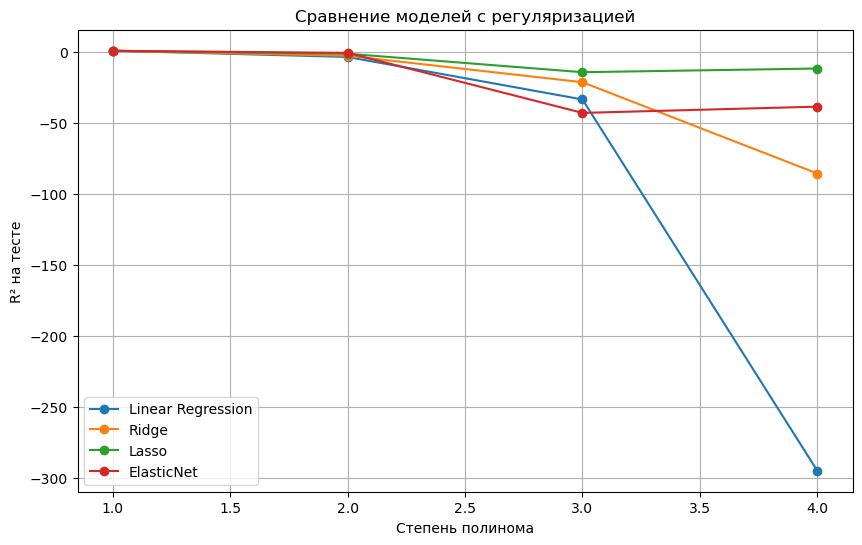

In [103]:
# Запуск расчета
results_test_polinomial_features = polynomial_regression_with_regularization(X, y)

In [293]:
# Подбор гиперпараметров для CatBoost

# Глобальные переменные для данных (предполагается, что они уже определены)
X = X[results_features_selection[results_features_selection['model'] == 'CatBoost']['best_features'][6]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train[results_features_selection[results_features_selection['model'] == 'CatBoost']['best_features'][6]].drop(results_indices_selection[results_indices_selection['model'] == 'CatBoost']['removed_indices'][6])
y_train = y_train.drop(results_indices_selection[results_indices_selection['model'] == 'CatBoost']['removed_indices'][6])


def objective(trial):
    cb_params = {
        'iterations': trial.suggest_int('iterations', 50, 300),
        'depth': trial.suggest_int('depth', 4, 8),  # Узкий диапазон вокруг дефолтного 6
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),  # Верхняя граница 0.1 вместо 0.3
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 5),  # Более узкий диапазон
        'random_strength': trial.suggest_float('random_strength', 0.1, 2),  # Уменьшен верхний предел
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 0.5),  # Понижен максимум
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 20),  # Уменьшен диапазон
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise']),
        'random_seed': 42,
        'verbose': False
    }

    model = CatBoostRegressor(**cb_params)
    model.fit(X_train, y_train, early_stopping_rounds=20, eval_set=(X_test, y_test))
    y_pred = model.predict(X_test)
    
    # Расчет метрик
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    # Сохраняем R² как дополнительный атрибут
    trial.set_user_attr("r2", r2)
    
    return rmse

# Настройка исследования Optuna
study = optuna.create_study(
    direction='minimize',  # Минимизируем RMSE
    sampler=TPESampler(seed=42),
    pruner=MedianPruner(n_warmup_steps=5)
)

def log_trial_progress(study, trial):
    """Callback для логирования прогресса с отображением RMSE и R²"""
    if trial.number == 0:
        print("| Trial |   RMSE   |   R²    |")
        print("|-------|----------|---------|")
    
    rmse = trial.value if trial.value is not None else float('inf')
    r2 = trial.user_attrs.get("r2", 0.0)
    
    print(f"| {trial.number:5} | {rmse:.6f} | {r2:.6f} |")

# Запуск оптимизации
try:
    print("Optimizing CatBoost...")
    study.optimize(
        objective,
        n_trials=500,
        #callbacks=[log_trial_progress],
        gc_after_trial=True
    )
except KeyboardInterrupt:
    print("\nOptimization stopped by user").get_params()

# Анализ результатов
if len(study.trials) > 0:
    # Найдем trial с максимальным R² среди лучших по RMSE
    best_trials_cb = sorted(
        [t for t in study.trials if t.value is not None],
        key=lambda x: (x.value, -x.user_attrs["r2"])
    )
    
    best_trial_cb = best_trials_cb[0]
    
    print("\nBest trial:")
    print(f"  RMSE: {best_trial_cb.value:.6f}")
    print(f"  R²: {best_trial_cb.user_attrs['r2']:.6f}")
    print("\nBest params:")
    for key, value in best_trial_cb.params.items():
        print(f"  {key}: {value}")
    
   

Optimizing CatBoost...

Best trial:
  RMSE: 285.256095
  R²: 0.589715

Best params:
  iterations: 273
  depth: 5
  learning_rate: 0.07735178658615308
  l2_leaf_reg: 1.0080799048847042
  random_strength: 1.564234627121799
  bagging_temperature: 0.4168404884552308
  min_data_in_leaf: 1
  grow_policy: Depthwise


In [116]:
# Подбор гиперпараметров для XGBoost

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train[results_features_selection[results_features_selection['model'] == 'XGBoost']['best_features'][5]].drop(results_indices_selection[results_indices_selection['model'] == 'XGBoost']['removed_indices'][5])
y_train = y_train.drop(results_indices_selection[results_indices_selection['model'] == 'XGBoost']['removed_indices'][5])
X_test = X_test[results_features_selection[results_features_selection['model'] == 'XGBoost']['best_features'][5]]

def objective_xgb(trial):
    """Функция для оптимизации гиперпараметров XGBoost"""
    
    xgb_params = {
        'n_estimators': trial.suggest_int('xgb_n_estimators', 50, 500),
        'max_depth': trial.suggest_int('xgb_max_depth', 2, 12),
        'learning_rate': trial.suggest_float('xgb_learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('xgb_subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('xgb_colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('xgb_gamma', 0, 5),
        'reg_alpha': trial.suggest_float('xgb_reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('xgb_reg_lambda', 0, 10),
        'random_state': 42,
        'n_jobs': -1
    }

    model = XGBRegressor(**xgb_params)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    trial.set_user_attr("r2", r2)
    return rmse


study_xgb = optuna.create_study(
    direction='minimize',
    sampler=TPESampler(seed=42),
    pruner=MedianPruner(n_warmup_steps=5)
)

try:
    print("Optimizing XGBoost...")
    study_xgb.optimize(
        objective_xgb,
        n_trials=200,
        #callbacks=[log_trial_progress],
        gc_after_trial=True
    )
except KeyboardInterrupt:
    print("\nOptimization stopped by user")

if len(study_xgb.trials) > 0:
    best_trial_xg = study_xgb.best_trial
    print("\nBest XGBoost params:")
    for key, value in best_trial_xg.params.items():
        print(f"  {key}: {value}")
    print(f"Best RMSE: {best_trial_xg.value:.6f}")
    print(f"Best R²: {best_trial_xg.user_attrs['r2']:.6f}")
    
   

Optimizing XGBoost...

Best XGBoost params:
  xgb_n_estimators: 289
  xgb_max_depth: 4
  xgb_learning_rate: 0.015037829910092374
  xgb_subsample: 0.9919503638648259
  xgb_colsample_bytree: 0.9452231580644855
  xgb_gamma: 1.4506133459456256
  xgb_reg_alpha: 3.582128157020251
  xgb_reg_lambda: 1.3231820148540026
Best RMSE: 280.948805
Best R²: 0.602011


In [117]:
# Подбор гиперпараметров для RandomForest

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train[results_features_selection[results_features_selection['model'] == 'RandomForest']['best_features'][4]].drop(results_indices_selection[results_indices_selection['model'] == 'RandomForest']['removed_indices'][4])
y_train = y_train.drop(results_indices_selection[results_indices_selection['model'] == 'RandomForest']['removed_indices'][4])
X_test = X_test[results_features_selection[results_features_selection['model'] == 'RandomForest']['best_features'][4]]

def objective_rf(trial):
    """Функция для оптимизации гиперпараметров RandomForest"""
    
    rf_params = {
        'n_estimators': trial.suggest_int('rf_n_estimators', 50, 500),
        'max_depth': trial.suggest_int('rf_max_depth', 3, 30),
        'min_samples_split': trial.suggest_int('rf_min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('rf_min_samples_leaf', 1, 10),
        'max_features': trial.suggest_float('rf_max_features', 0.1, 1.0),
        'bootstrap': trial.suggest_categorical('rf_bootstrap', [True, False]),
        'random_state': 42,
        'n_jobs': -1
    }

    model = RandomForestRegressor(**rf_params)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    trial.set_user_attr("r2", r2)
    return rmse


study_rf = optuna.create_study(
    direction='minimize',
    sampler=TPESampler(seed=42),
    pruner=MedianPruner(n_warmup_steps=5)
)

try:
    print("Optimizing RandomForest...")
    study_rf.optimize(
        objective_rf,
        n_trials=200,
        #callbacks=[log_trial_progress],
        gc_after_trial=True
    )
except KeyboardInterrupt:
    print("\nOptimization stopped by user")

if len(study_rf.trials) > 0:
    best_trial_rf = study_rf.best_trial
    print("\nBest RandomForest params:")
    for key, value in best_trial_rf.params.items():
        print(f"  {key}: {value}")
    print(f"Best RMSE: {best_trial_rf.value:.6f}")
    print(f"Best R²: {best_trial_rf.user_attrs['r2']:.6f}")



Optimizing RandomForest...

Best RandomForest params:
  rf_n_estimators: 474
  rf_max_depth: 24
  rf_min_samples_split: 4
  rf_min_samples_leaf: 1
  rf_max_features: 0.5611880870028121
  rf_bootstrap: False
Best RMSE: 263.099358
Best R²: 0.650976


In [118]:
# Собираем лучшие результаты
best_results_total = []
linear = {
        'model': results_indices_selection[results_indices_selection['model'] == 'LinearRegression']['model'][0],
        'best_r2': results_indices_selection[results_indices_selection['model'] == 'LinearRegression']['best_r2'][0],
        'count_features': len(results_features_selection[results_features_selection['model'] == 'LinearRegression']['best_features'][0]),
        'count_strings': len(results_indices_selection[results_indices_selection['model'] == 'LinearRegression']['indices'][0])
    }
best_results_total.append(linear)
ridge = {
        'model': results_indices_selection[results_indices_selection['model'] == 'Ridge']['model'][1],
        'best_r2': ridge_results['best_score'],
        'count_features': len(results_features_selection[results_features_selection['model'] == 'Ridge']['best_features'][1]),
        'count_strings': len(results_indices_selection[results_indices_selection['model'] == 'Ridge']['indices'][1])
    }
best_results_total.append(ridge)
lasso = {
        'model': results_indices_selection[results_indices_selection['model'] == 'Lasso']['model'][2],
        'best_r2': lasso_results['best_score'],
        'count_features': len(results_features_selection[results_features_selection['model'] == 'Lasso']['best_features'][2]),
        'count_strings': len(results_indices_selection[results_indices_selection['model'] == 'Lasso']['indices'][2])
    }
best_results_total.append(lasso)
elastic = {
        'model': results_indices_selection[results_indices_selection['model'] == 'ElasticNet']['model'][3],
        'best_r2': elastic_results['best_score'],
        'count_features': len(results_features_selection[results_features_selection['model'] == 'ElasticNet']['best_features'][3]),
        'count_strings': len(results_indices_selection[results_indices_selection['model'] == 'ElasticNet']['indices'][3])
    }
best_results_total.append(elastic)
rf = {
        'model': results_indices_selection[results_indices_selection['model'] == 'RandomForest']['model'][4],
        'best_r2': best_trial_rf.user_attrs['r2'],
        'count_features': len(results_features_selection[results_features_selection['model'] == 'RandomForest']['best_features'][4]),
        'count_strings': len(results_indices_selection[results_indices_selection['model'] == 'RandomForest']['indices'][4])
    }
best_results_total.append(rf)
xg = {
        'model': results_indices_selection[results_indices_selection['model'] == 'XGBoost']['model'][5],
        'best_r2': best_trial_xg.user_attrs['r2'],
        'count_features': len(results_features_selection[results_features_selection['model'] == 'XGBoost']['best_features'][5]),
        'count_strings': len(results_indices_selection[results_indices_selection['model'] == 'XGBoost']['indices'][5])
    }
best_results_total.append(xg)
cb = {
        'model': results_indices_selection[results_indices_selection['model'] == 'CatBoost']['model'][6],
        'best_r2': best_trial_cb.user_attrs['r2'],
        'count_features': len(results_features_selection[results_features_selection['model'] == 'CatBoost']['best_features'][6]),
        'count_strings': len(results_indices_selection[results_indices_selection['model'] == 'CatBoost']['indices'][6])
    }
best_results_total.append(cb)

best_results_total_df = pd.DataFrame(best_results_total)

In [125]:
# Лучшие результаты
best_results_total_df

,model,best_r2,count_features,count_strings
0,LinearRegression,0.717347,114,491
1,Ridge,0.691435,114,478
2,Lasso,0.713671,114,461
3,ElasticNet,0.550389,116,373
4,RandomForest,0.650976,27,682
5,XGBoost,0.602011,18,762
6,CatBoost,0.546018,36,757
